<a href="https://colab.research.google.com/github/filipemtz/neuralnets/blob/main/mlp_mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilayer Perceptron (MLP) para Reconhecimento de Digitos

Exemplo mostrando como treinar uma rede neural do tipo multilayer perceptron (MLP) para reconhecimento de digitos manuscritos usando a base de dados MNIST e a biblioteca pytorch. O exemplo é completamente baseado nos tutoriais acessíveis nos links abaixo. O primeiro é o tutorial básico de redes neurais do pytoch e o segundo compara a implementa tradicional com a lib de alto nivel lightning que tem mais ou menos o mesmo papel do keras. 

https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

https://www.machinecurve.com/index.php/2021/01/26/creating-a-multilayer-perceptron-with-pytorch-and-lightning/

In [ ]:
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

trainval = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
test = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())

train_size = int(trainval.data.shape[0] * 0.8)
val_size = trainval.data.shape[0] - train_size 
test_size = test.data.shape[0]

train, val = random_split(trainval, [train_size, val_size])

train_ds = DataLoader(train, batch_size=2048, shuffle=True, num_workers=4)
val_ds = DataLoader(val, batch_size=2048, shuffle=True, num_workers=1)
test_ds = DataLoader(test, batch_size=2048, shuffle=True, num_workers=1)

print(train_ds)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 149.9 MB 26 kB/s 
     |████████████████████████████████| 57 kB 2.4 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.284 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


In [ ]:
import torch

#import torch_xla
#import torch_xla.core.xla_model as xm

# Acquires the default Cloud TPU core and moves the model to it
# device = xm.xla_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


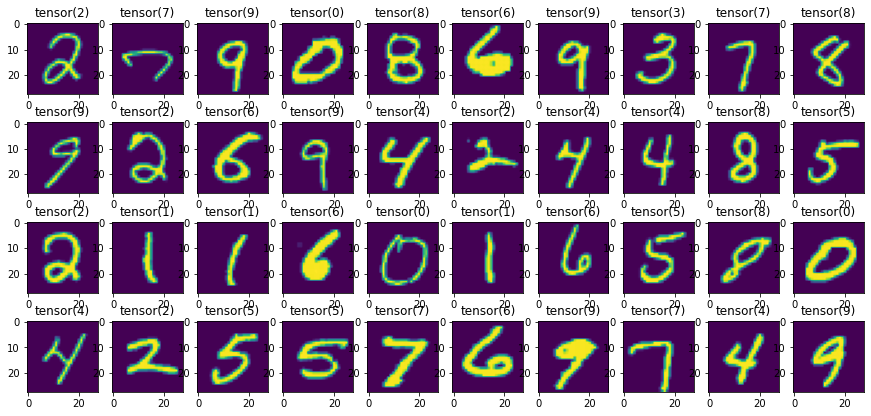

In [ ]:

import matplotlib.pyplot as plt 
%matplotlib inline 

# Get a batch of training data
imgs, labels = next(iter(train_ds))

plt.figure(figsize=(15, 7))
for i in range(40):
  plt.subplot(4, 10, i+1)
  plt.title(str(labels[i]))
  plt.imshow(np.squeeze(imgs[i].numpy())) # [1, 1, 28, 28] -> [28, 28]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
)

print(net)

net = net.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
import time 

N_EPOCHS = 10
LEARNING_RATE = 0.001

# nn.CrossEntropyLoss's input is expected to contain raw, unnormalized scores for each class.
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
loss_function = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# train loop
for epoch in range(N_EPOCHS):

  train_loss = 0
  train_hits = 0
  count = 0

  net.train()
  train_start = time.time()
  for imgs, targets in train_ds: # repeat for each batch
    imgs = imgs.to(device)
    targets = targets.to(device)
    optimizer.zero_grad() # reinitialize gradients
    preds = net(imgs) # forward pass
    loss = loss_function(preds, targets)  # compute loss
    loss.backward()  # compute gradients in a backward pass
    optimizer.step()  # update weights
    train_loss += loss
    train_hits += torch.sum(torch.argmax(preds, dim=1) == targets.data)
    count += 1

  train_loss /= train_size
  train_acc = train_hits / train_size
  train_losses.append(train_loss)
  train_accuracies.append(train_acc)

  train_time = (time.time() - train_start) / count

  val_loss = 0
  val_hits = 0
  count = 0

  val_start = time.time()

  net.eval()

  with torch.no_grad():
    for imgs, targets in val_ds: # repeat for each batch
      imgs = imgs.to(device)
      targets = targets.to(device)
      preds = net(imgs) # forward pass
      loss = loss_function(preds, targets)  # compute loss
      val_loss += loss
      val_hits += torch.sum(torch.argmax(preds, dim=1) == targets.data)
      count += 1

  val_loss /= val_size
  val_losses.append(val_loss)
  val_acc = val_hits / val_size
  val_accuracies.append(val_acc)

  val_time = (time.time() - val_start) / count

  print(f"epoch: {epoch} loss: {train_loss} acc: {train_acc} val_loss: {val_loss} val_acc: {val_acc} train_time: {train_time} val_time: {val_time}")


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 0 loss: 0.15166358649730682 acc: 0.9556666612625122 val_loss: 0.1726011484861374 val_acc: 0.949916660785675 train_time: 0.19980513056119284 val_time: 0.19317853450775146
epoch: 1 loss: 0.13687247037887573 acc: 0.9601250290870667 val_loss: 0.16339947283267975 val_acc: 0.9514166712760925 train_time: 0.19089053074518839 val_time: 0.19451157251993814
epoch: 2 loss: 0.12645336985588074 acc: 0.9633958339691162 val_loss: 0.15821601450443268 val_acc: 0.9520000219345093 train_time: 0.1954412360986074 val_time: 0.1950850486755371
epoch: 3 loss: 0.11825678497552872 acc: 0.9655625224113464 val_loss: 0.15217489004135132 val_acc: 0.9544166922569275 train_time: 0.19495874643325806 val_time: 0.19639873504638672
epoch: 4 loss: 0.11043594032526016 acc: 0.9682499766349792 val_loss: 0.1448550969362259 val_acc: 0.9565833210945129 train_time: 0.19411131739616394 val_time: 0.1966259479522705
epoch: 5 loss: 0.1030174270272255 acc: 0.9700000286102295 val_loss: 0.14319093525409698 val_acc: 0.959166646003

Text(0.5, 1.0, 'accuracy')

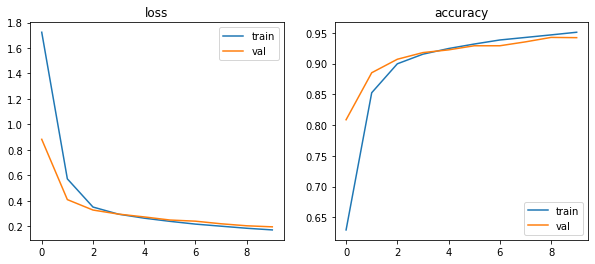

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.legend()
plt.title("accuracy")


In [ ]:
test_loss = 0
test_hits = 0

net.eval()

with torch.no_grad():
  for imgs, targets in test_ds: # repeat for each batch
    imgs = imgs.to(device)
    targets = targets.to(device)
    preds = net(imgs) # forward pass
    loss = loss_function(preds, targets)  # compute loss
    test_loss += loss
    test_hits += torch.sum(torch.argmax(preds, dim=1) == targets.data)

test_loss /= test_size
test_acc = test_hits / test_size

print(f"test loss: {test_loss} test accuracy: {test_acc:.2f}")

test loss: 0.18049383163452148 test accuracy: 0.95


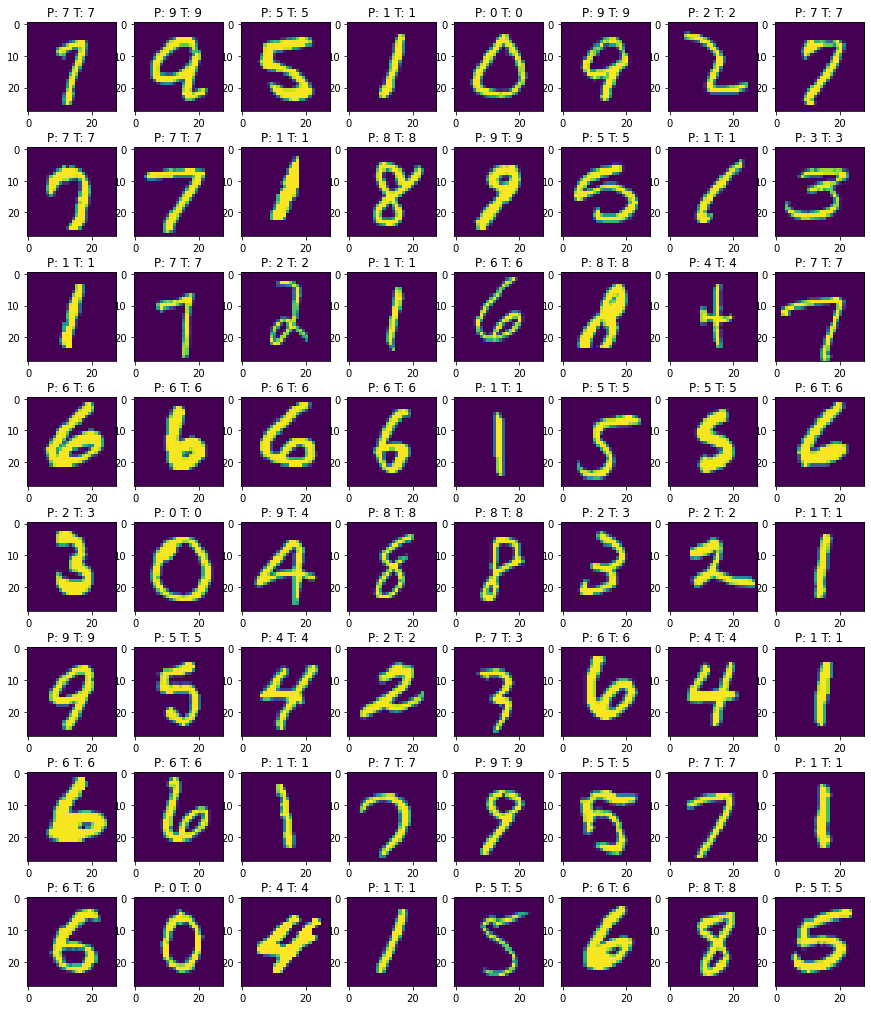

In [ ]:
preds = preds.to("cpu")
targets = targets.to("cpu")
imgs = imgs.to("cpu")

plt.figure(figsize=(15, 18))
for i in range(64):
  plt.subplot(8, 8, i+1)
  cls = np.argmax(preds[i])
  plt.title(f"P: {cls} T: {targets[i]}")
  plt.imshow(np.squeeze(imgs[i]))